
Projekt 1: Verkehrszeichenerkennung mit Keras


In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import csv
import PIL

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses,  metrics, regularizers, utils
from tensorflow.keras.layers import InputLayer, Dropout, BatchNormalization, MaxPooling2D, Conv2D,Flatten,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from sklearn.model_selection import train_test_split
from numpy import genfromtxt
from pandas import read_csv
from skimage import color, exposure, transform, io
from PIL import Image
from textwrap import wrap
from sklearn.utils import shuffle

Unter MacOS muss das Backend von matplotlib  veraendert werden, 
ansonsten gibt es eine Fehlermeldung
matplotlib.use('TkAgg')

In [4]:
IMG_SIZE = 32
MAX_PICTURES_PER_CLASS = 200
NUM_BATCHES = 64
NUM_EPOCHS = 40 

In [5]:
TRAIN_IMAGES_PATH = './img/train'
TEST_IMAGES_PATH = "./img/test"

In [6]:
 # Das erste Bild von jeder Kategorie wird zwischengespeichert
 # und angezeigt
first_images = []
num_roadsign_classes = 0  

Funktion, die das Bild zu einer bestimmten Größe skaliert, 
da jedes Bild innerhalb der Verzeichnisse unterschiedlichen Grössen
besitzen

In [7]:
def preprocess_image(img):
    img = np.asarray(img)
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

In [8]:
# Funktion adaptiert von readTrafficSigns.py vom Institut für Neuroninformatik    
def load_roadsigns_data(rootpath):

    images = [] # Array von Bilder images
    labels = [] # Array von corresponding labels
    
    nbOfImages =0
    global num_roadsign_classes
    
    #  Hinweis: unter MacOS wird der versteckte Ordner
    # ".DS_STORE" mitgezählt
    num_roadsign_classes = len([pic for pic in os.listdir("./img/train") if not pic.startswith(".")])

    # Die Schleife geht über alle Verzeichnisse
    for c in range(0,num_roadsign_classes):
        prefix = rootpath + '/' + format(c, '05d') + '/' # Unterverzeichnis für die Kategorie
        gt_file = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gt_reader = csv.reader(gt_file, delimiter=';') 
        next(gt_reader) # Iterator
        
         # Jede zeile der GT-XXXXX.csv Datei wird eingelesen
        for row_index, row in enumerate(gt_reader):
            jpgfile = Image.open(prefix + row[0])
            nbOfImages +=1

            if(row_index>=MAX_PICTURES_PER_CLASS):
                break
            # Wir wollen nicht durch alle Bilder pro Verzeichnis durchgehen (das Training kann länger dauern)
            # wir setzten eine Grenze von 250 zu analysierenden Bildern pro 
            # Verzeichnis. Erhöhen Sie den Wert von MAX_PICTURE_PER_CLASS,
            # wenn Sie alle Bilder berücksichtigen möchten
            gs_image = preprocess_image(jpgfile) # Skaliert das Bild
            images.append(gs_image) 
            labels.append(row[7]) # die Spalte 8 beinhaltet das Label

            if(row_index==0):
                first_images.append(gs_image)
            
            if(nbOfImages%1000 == 0):
                print("Analysierte Bilder :{}".format(nbOfImages))

        gt_file.close()

    return np.array(images)/255.0, np.array(to_categorical(labels, num_classes=num_roadsign_classes))

In [9]:
# Gibt den Namen der Kategorie zurück
def get_roadsign_name(index):
    return sign_names.values[index][1]

In [10]:
# Ausgabe der Bilder
def display_roadsigns_classes():
    plt.rc('font', size=6)    
    plt.rcParams["figure.figsize"] = (10,10)
    fig, axarr = plt.subplots(6,8)
    num = 0
    for i in range(0,6):
        for p in range(0,8):
            axarr[i][p].axis('off')
            if(num<num_roadsign_classes):
                axarr[i,p].imshow(first_images[num],interpolation='nearest')
                roadsign_name = "\n".join(wrap(get_roadsign_name(num),15))
                axarr[i,p].set_title("[" + str(num) + "]\n"+roadsign_name)
                num +=1
    fig.suptitle('German Traffic Sign Recognition Benchmark',fontsize=16,fontweight="bold")
    plt.subplots_adjust(hspace=1)
    plt.show()

In [11]:
# Aufbau des Keras Modells 
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization( input_shape = (IMG_SIZE,IMG_SIZE,3)))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape =
     (IMG_SIZE,IMG_SIZE,3)))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2,2), activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2,2), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(num_roadsign_classes, activation='softmax'))
    return model

In [12]:
# Namen der Verkehrsschilder werden geladen
sign_names = read_csv('road_signs_names.csv', delimiter=',',dtype=None)

In [13]:
# Wir laden die Bilder und die Labels dank der load_roadsigns_data() Funktion
images, labels = load_roadsigns_data(TRAIN_IMAGES_PATH)
images, labels  = shuffle(images,labels,random_state=42)
trainImages, valImages, trainLabels, valLabels = train_test_split(images, labels, test_size = 0.2, random_state = 42)

Analysierte Bilder :1000
Analysierte Bilder :2000
Analysierte Bilder :3000
Analysierte Bilder :4000
Analysierte Bilder :5000
Analysierte Bilder :6000
Analysierte Bilder :7000
Analysierte Bilder :8000


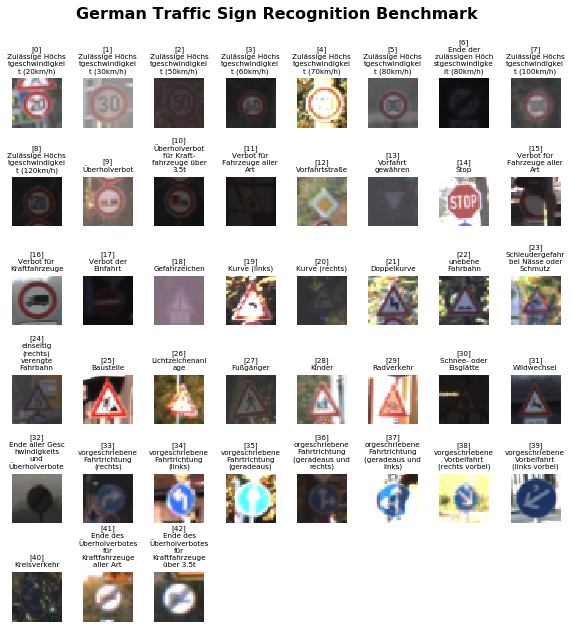

In [14]:
# Die Verkehrsschilder werden angezeigt
display_roadsigns_classes()

In [15]:
optimizer = Adam(lr=0.001)
model = build_model()

In [16]:
# Da wir ein Klassifikationsaufgabe haben, verwenden wir categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ["accuracy"])#,"mae"])

In [17]:
# Imagegenerator für die Trainingsdaten
train_imagedatagenerator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=[0.4,1.1],
    shear_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip = False)

In [18]:
train_imagedatagenerator.fit(trainImages)

In [19]:
# ImageDataGenerator für die Validierunsdaten
val_imagedatagenerator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=[0.4,1.1],
    shear_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip = False)

In [20]:
val_imagedatagenerator.fit(valImages)

In [ ]:
# Option 1: Training des Modells Ohne Datenaugmentierung
model.fit(trainImages,trainLabels, epochs=NUM_EPOCHS, batch_size=NUM_BATCHES,verbose=1,validation_data=(valImages,valLabels),shuffle=True)

Train on 6880 samples, validate on 1720 samples
Epoch 1/40
6880/6880 [==============================] - 8s 1ms/sample - loss: 3.3636 - accuracy: 0.0884 - val_loss: 3.9435 - val_accuracy: 0.0209
Epoch 2/40
6880/6880 [==============================] - 8s 1ms/sample - loss: 2.2205 - accuracy: 0.3506 - val_loss: 3.5708 - val_accuracy: 0.0581
Epoch 3/40
6880/6880 [==============================] - 8s 1ms/sample - loss: 1.2095 - accuracy: 0.6358 - val_loss: 3.1023 - val_accuracy: 0.2198
Epoch 4/40
6880/6880 [==============================] - 8s 1ms/sample - loss: 0.7445 - accuracy: 0.7673 - val_loss: 2.4637 - val_accuracy: 0.3715
Epoch 5/40
6880/6880 [==============================] - 8s 1ms/sample - loss: 0.4949 - accuracy: 0.8468 - val_loss: 0.9570 - val_accuracy: 0.8163
Epoch 6/40
6880/6880 [==============================] - 8s 1ms/sample - loss: 0.3425 - accuracy: 0.8923 - val_loss: 0.4462 - val_accuracy: 0.8994
Epoch 7/40
2240/6880 [========>.....................] - ETA: 4s - loss: 0.31

Option 2: Training des Modells mit Datenaugmentierung
model.fit_generator(train_imagedatagenerator.flow(trainImages, trainLabels, batch_size=NUM_BATCHES), steps_per_epoch= trainImages.shape[0]/NUM_BATCHES, epochs=NUM_EPOCHS,validation_data=(valImages,valLabels),verbose=1)

In [ ]:
# Wir laden nun das Testdataset
test_images, test_labels = load_roadsigns_data(TEST_IMAGES_PATH)
test_images, test_labels  = shuffle(test_images,test_labels,random_state=42)

In [ ]:
scores = model.evaluate(test_images,test_labels,verbose=1)

scores = model.evaluate(val_imagedatagenerator.flow(valImages,valLabels),verbose=1)
scores = model.evaluate(valImages,valLabels,verbose=1)

In [ ]:
print('Loss:', scores[0])
print('Accuracy:', scores[1])

In [ ]:
# Das Model wird gespeichert
model.save('road_signs_model.h5')